In [60]:
import pandas as pd

data=pd.read_csv("/content/monthly-housing_DS9.csv")
display(data.head(10))

,date,house_price_index,numsold
0,01-01-1991,100.00,30
1,02-01-1991,100.48,40
2,03-01-1991,100.74,51
3,04-01-1991,100.75,50
4,05-01-1991,100.92,47
5,06-01-1991,101.40,47
6,07-01-1991,101.36,43
7,08-01-1991,101.31,46
8,09-01-1991,101.41,37
9,10-01-1991,101.62,41


In [61]:
!pip install --no-cache-dir "numpy==1.26.4"
!pip install --no-cache-dir "pmdarima==2.0.4"

In [62]:
# --- core ---
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- stats & models ---
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pm

# --- metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [63]:
# STEP 1 — IMPORTS & SETTINGS
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- plotting defaults (optional) ---
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

# EXPLANATION:
# Imports all libraries for EDA, decomposition, stationarity tests, ES models, auto-ARIMA, and metrics.


In [64]:
# STEP 2 — LOAD & PREPROCESS (STRICT MM/DD/YYYY PARSING)

path = "/content/monthly-housing_DS9.csv"  # adjust if needed
raw = pd.read_csv(path, dtype=str)  # read as strings to control parsing

# clean headers
raw.columns = [c.strip().lower() for c in raw.columns]

# normalize separators to "/" then parse EXACT format MM/DD/YYYY
raw['date'] = (
    raw['date'].astype(str).str.strip().str.replace('-', '/', regex=False)
)
raw['date'] = pd.to_datetime(raw['date'], format='%m/%d/%Y', errors='raise')

# keep last occurrence if any duplicated calendar dates
raw = raw.drop_duplicates(subset=['date'], keep='last').sort_values('date')

# set index and align to Monthly Start (MS)
data = raw.set_index('date').sort_index()
data = data.asfreq('MS')  # ensures each month has a 1st-of-month timestamp

# fill any gaps conservatively
data = data.ffill().bfill()

# sanity check
print("Min date:", data.index.min(), "| Max date:", data.index.max())
print("Last 6 stamps:\n", data.index[-6:])
display(data.tail(10))

# EXPLANATION:
# Forces MM/DD/YYYY parsing, removes any duplicate dates, aligns to monthly (MS),
# and fills gaps so downstream models work cleanly.


Min date: 1991-01-01 00:00:00 | Max date: 2013-04-01 00:00:00
Last 6 stamps:
 DatetimeIndex(['2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01',
               '2013-03-01', '2013-04-01'],
              dtype='datetime64[ns]', name='date', freq='MS')


,house_price_index,numsold
date,,
2012-07-01,192.66,33
2012-08-01,192.47,31
2012-09-01,192.41,30
2012-10-01,193.05,29
2012-11-01,193.33,28
2012-12-01,192.7,28
2013-01-01,192.26,32
2013-02-01,194.31,36
2013-03-01,198.06,41


In [65]:
# STEP 3 — SELECT TARGET & SUMMARY STATS
target_col = "house_price_index"  # switch to "numsold" if needed
y = data[target_col].astype(float)

display(y.describe())

# EXPLANATION:
# Picks the modeling target and prints summary statistics to understand scale and spread.


,house_price_index
count,268.000000
mean,158.834478
std,41.890440
min,100.000000
25%,116.977500
50%,157.935000
75%,194.537500
max,228.710000


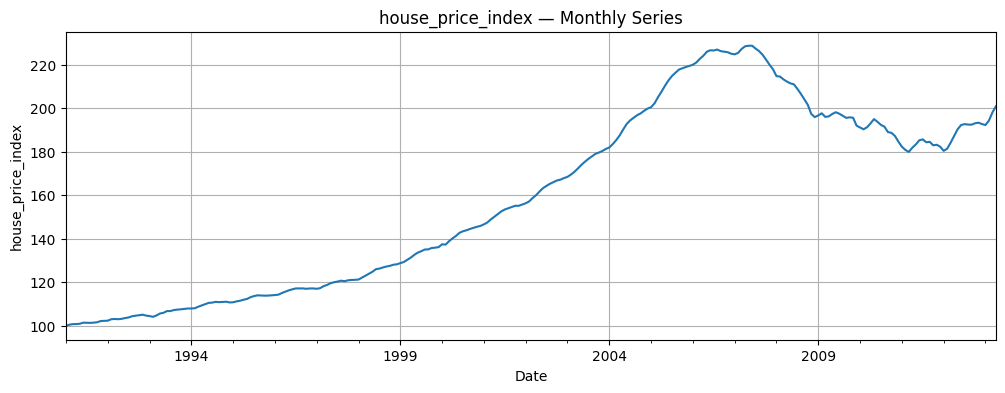

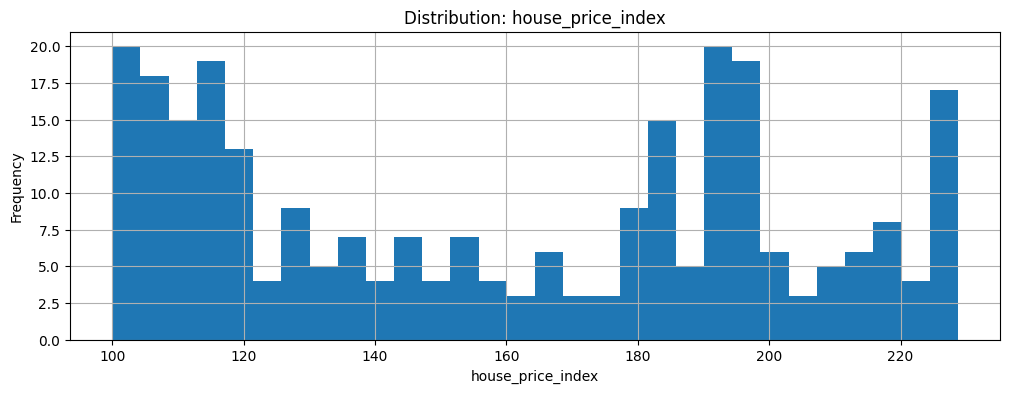

In [66]:
# STEP 4 — EDA PLOTS (LINE + HISTOGRAM)
ax = y.plot(title=f"{target_col} — Monthly Series")
ax.set_ylabel(target_col)
ax.set_xlabel("Date")
plt.show()

y.hist(bins=30)
plt.title(f"Distribution: {target_col}")
plt.xlabel(target_col)
plt.ylabel("Frequency")
plt.show()

# EXPLANATION:
# Visualizes overall trend/seasonality (line) and the distribution (histogram).


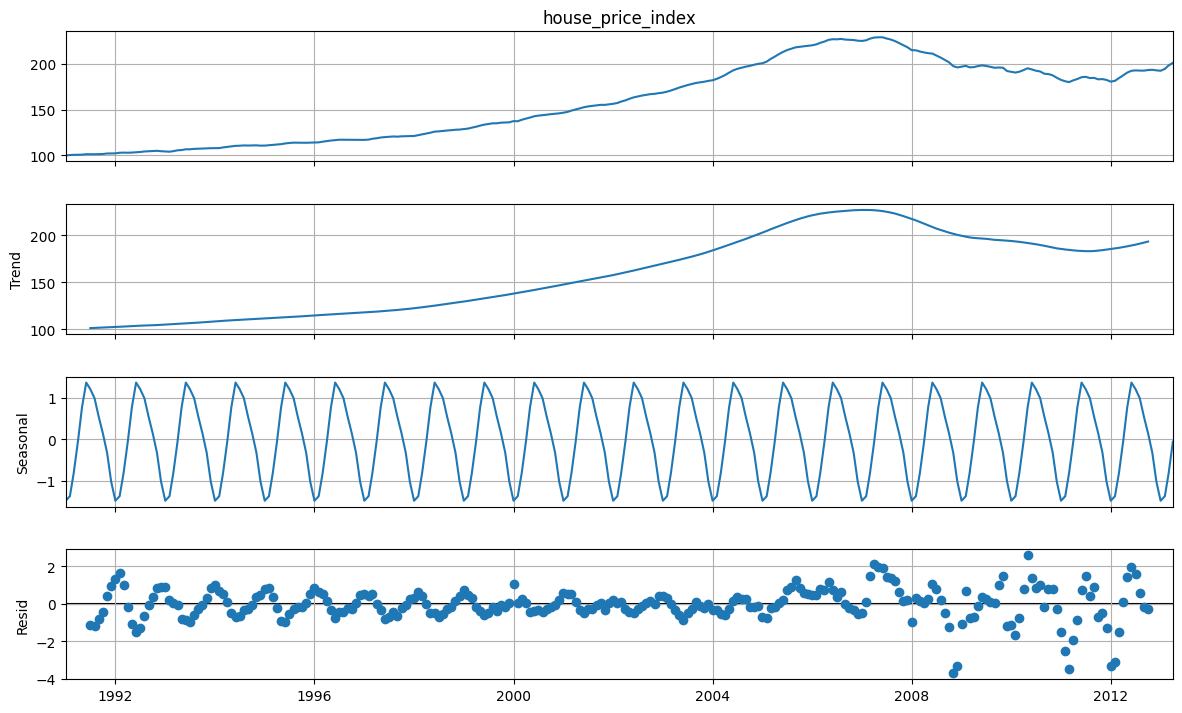

In [67]:
# STEP 5 — SEASONAL DECOMPOSITION
decomp = seasonal_decompose(y, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()

# EXPLANATION:
# Splits the series into trend, seasonal, and residual components using monthly seasonality (12).


In [68]:
# STEP 6 — STATIONARITY TESTS

def adf_test(series):
    stat, p, lags, nobs, *_ = adfuller(series.dropna(), autolag='AIC')
    return {"ADF Statistic": stat, "p-value": p, "Used lags": lags, "Num obs": nobs}

def kpss_test(series, regression='c', nlags='auto'):
    stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags=nlags)
    return {"KPSS Statistic": stat, "p-value": p, "Used lags": lags}

print("ADF:", adf_test(y))
print("KPSS:", kpss_test(y))

# EXPLANATION:
# ADF (want p<0.05) and KPSS (want p>0.05) provide a read on stationarity; ARIMA will difference if needed.


ADF: {'ADF Statistic': -1.1976090462121176, 'p-value': 0.6746233932371463, 'Used lags': 16, 'Num obs': 251}
KPSS: {'KPSS Statistic': 2.2196643496477777, 'p-value': 0.01, 'Used lags': 10}


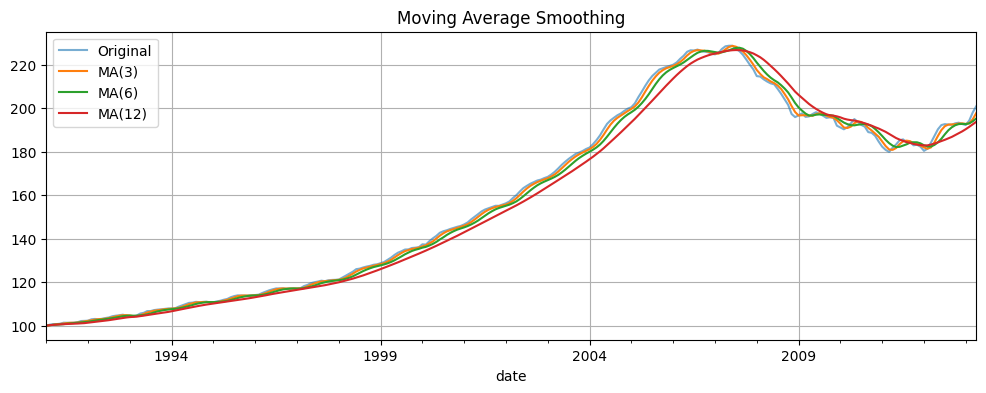

In [69]:
# STEP 7 — MOVING AVERAGE SMOOTHING
ma3  = y.rolling(3,  min_periods=1).mean()
ma6  = y.rolling(6,  min_periods=1).mean()
ma12 = y.rolling(12, min_periods=1).mean()

y.plot(label='Original', alpha=0.6)
ma3.plot(label='MA(3)')
ma6.plot(label='MA(6)')
ma12.plot(label='MA(12)')
plt.title("Moving Average Smoothing")
plt.legend()
plt.show()

# EXPLANATION:
# Overlays 3, 6, and 12-month moving averages to smooth noise and visualize underlying trend.


In [70]:
# STEP 8 — TRAIN/TEST SPLIT
test_horizon = 24
y_train = y.iloc[:-test_horizon]
y_test  = y.iloc[-test_horizon:]

print("Train:", y_train.index.min(), "→", y_train.index.max(), "| n =", len(y_train))
print("Test :", y_test.index.min(),  "→", y_test.index.max(),  "| n =", len(y_test))

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

def mape(a, f):
    a, f = np.array(a), np.array(f)
    return np.mean(np.abs((a - f) / np.clip(np.abs(a), 1e-8, None))) * 100

# EXPLANATION:
# Holds out the last 24 months for honest evaluation; defines RMSE and MAPE helpers.


Train: 1991-01-01 00:00:00 → 2011-04-01 00:00:00 | n = 244
Test : 2011-05-01 00:00:00 → 2013-04-01 00:00:00 | n = 24


In [71]:
# Replace the earlier RMSE helper with this compatible version
def rmse(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return np.sqrt(mean_squared_error(a, b))  # no 'squared' kwarg


,Model,MAE,RMSE,MAPE(%)
1,Holt,6.717047,7.539021,3.549907
0,SES,7.058750,8.839079,3.662103
2,Holt-Winters,13.761569,16.546953,7.163001


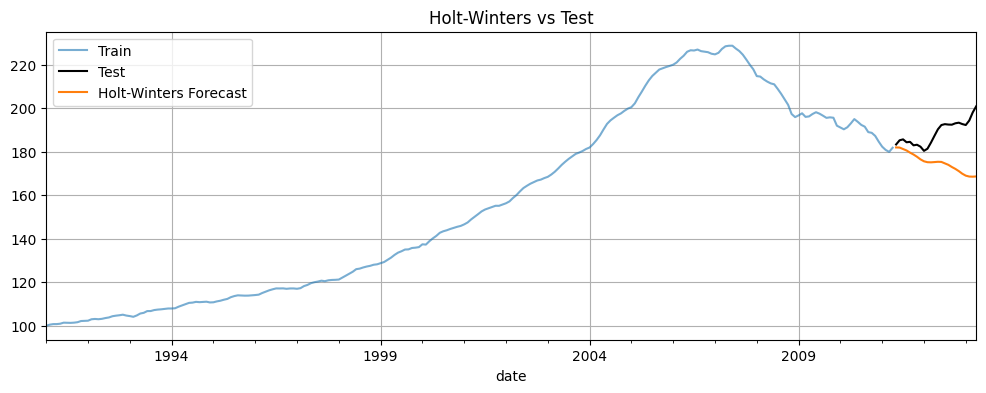

In [72]:
# STEP 9 — EXPONENTIAL SMOOTHING FAMILY

# Simple Exponential Smoothing
ses = SimpleExpSmoothing(y_train, initialization_method="estimated").fit()
ses_fc = ses.forecast(len(y_test))

# Holt trend method
holt = ExponentialSmoothing(y_train, trend='add', initialization_method="estimated").fit()
holt_fc = holt.forecast(len(y_test))

# Holt-Winters (trend + seasonality)
hw = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12,
                          initialization_method="estimated").fit()
hw_fc = hw.forecast(len(y_test))

# Metrics table
eval_table = pd.DataFrame({
    "Model": ["SES", "Holt", "Holt-Winters"],
    "MAE":  [mean_absolute_error(y_test, ses_fc),
             mean_absolute_error(y_test, holt_fc),
             mean_absolute_error(y_test, hw_fc)],
    "RMSE": [rmse(y_test, ses_fc),
             rmse(y_test, holt_fc),
             rmse(y_test, hw_fc)],
    "MAPE(%)": [mape(y_test, ses_fc),
                mape(y_test, holt_fc),
                mape(y_test, hw_fc)]
}).sort_values("RMSE")
display(eval_table)

# Visual check (HW example)
y_train.plot(label="Train", alpha=0.6)
y_test.plot(label="Test", color="black")
hw_fc.plot(label="Holt-Winters Forecast")
plt.title("Holt-Winters vs Test")
plt.legend()
plt.show()

# EXPLANATION:
# Fits SES, Holt, and Holt-Winters; compares on the test set and plots forecast vs actuals.


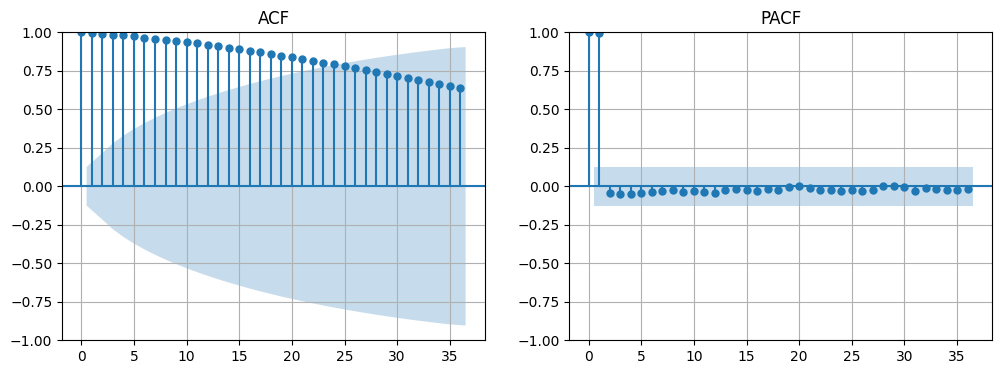

In [73]:
# STEP 10 — ACF & PACF PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(y_train, lags=36, ax=axes[0])
plot_pacf(y_train, lags=36, ax=axes[1], method="ywm")
axes[0].set_title("ACF")
axes[1].set_title("PACF")
plt.show()

# EXPLANATION:
# ACF/PACF help visualize autocorrelation patterns and support ARIMA order intuition.


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  244
Model:             SARIMAX(0, 2, 2)x(1, 0, [1], 12)   Log Likelihood                -237.835
Date:                              Thu, 25 Sep 2025   AIC                            485.669
Time:                                      22:27:04   BIC                            503.114
Sample:                                  01-01-1991   HQIC                           492.697
                                       - 04-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5524      0.035    -15.754      0.000      -0.621      -0.484
ma.L2         -0.17

,Model,MAE,RMSE,MAPE(%)
0,Auto-ARIMA,17.616457,21.223566,9.172615


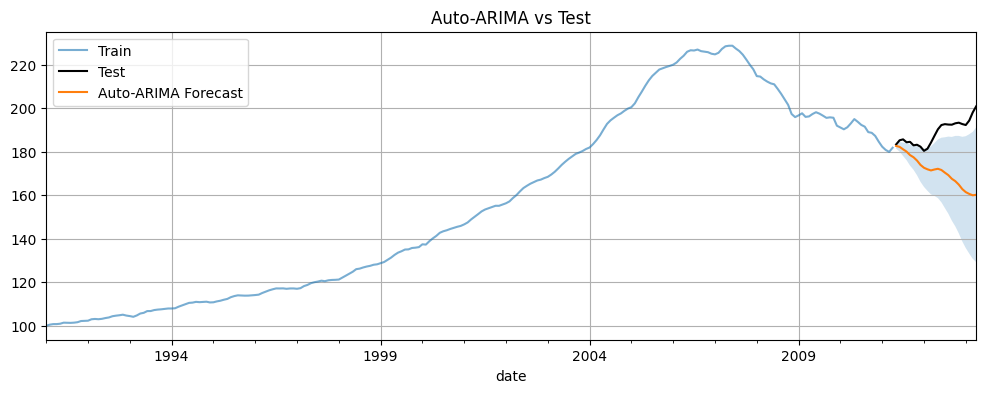

In [74]:
# STEP 11 — AUTO-ARIMA (SEASONAL)
auto_model = pm.auto_arima(
    y_train,
    start_p=0, start_q=0, max_p=5, max_q=5,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    seasonal=True, m=12,
    d=None, D=None, stepwise=True, trace=False,
    information_criterion='aic',
    suppress_warnings=True
)

print(auto_model.summary())

# Forecast on test
arima_fc, arima_ci = auto_model.predict(n_periods=len(y_test), return_conf_int=True)
arima_fc = pd.Series(arima_fc, index=y_test.index)

# Metrics
arima_row = pd.DataFrame({
    "Model": ["Auto-ARIMA"],
    "MAE":  [mean_absolute_error(y_test, arima_fc)],
    "RMSE": [rmse(y_test, arima_fc)],
    "MAPE(%)": [mape(y_test, arima_fc)]
})
display(arima_row)

# Plot forecast with CI
y_train.plot(label="Train", alpha=0.6)
y_test.plot(label="Test", color="black")
arima_fc.plot(label="Auto-ARIMA Forecast")
plt.fill_between(y_test.index, arima_ci[:,0], arima_ci[:,1], alpha=0.2)
plt.title("Auto-ARIMA vs Test")
plt.legend()
plt.show()

# EXPLANATION:
# Lets pmdarima select (p,d,q)(P,D,Q)m automatically, evaluates on the test set, and plots CIs.


In [75]:
# STEP 12 — MODEL COMPARISON
all_eval = pd.concat([eval_table, arima_row], ignore_index=True).sort_values("RMSE")
display(all_eval)

# EXPLANATION:
# Consolidates ES and Auto-ARIMA metrics to see the best model by error (lower is better).


,Model,MAE,RMSE,MAPE(%)
0,Holt,6.717047,7.539021,3.549907
1,SES,7.058750,8.839079,3.662103
2,Holt-Winters,13.761569,16.546953,7.163001
3,Auto-ARIMA,17.616457,21.223566,9.172615


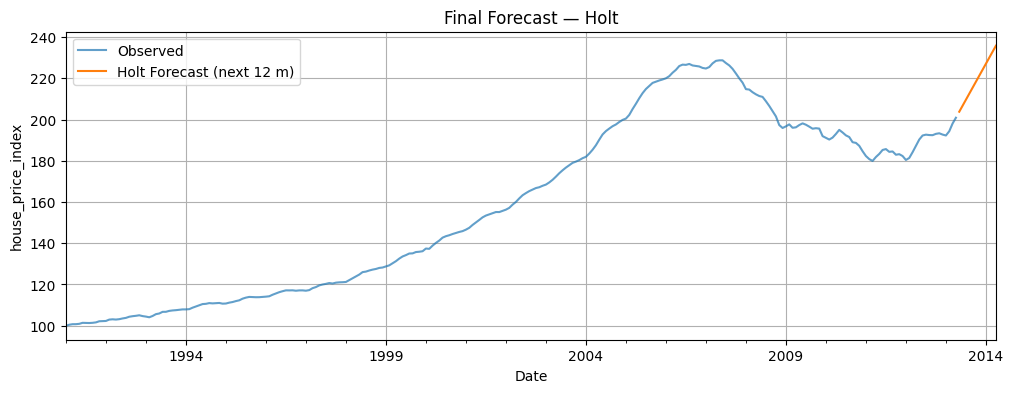

Saved → /content/final_forecast.csv


In [76]:
# STEP 13 — FINAL REFIT & FUTURE FORECAST (CORRECT START + MM/DD/YYYY CSV)

# Ensure monthly-start frequency and sorted index
y = y.asfreq('MS').sort_index()

# Pick best model from Step 12 table
best = all_eval.iloc[0]['Model']

# Refit on FULL data and produce values
if best == "Auto-ARIMA":
    final_model = pm.auto_arima(
        y,
        start_p=0, start_q=0, max_p=5, max_q=5,
        start_P=0, start_Q=0, max_P=2, max_Q=2,
        seasonal=True, m=12,
        d=None, D=None, stepwise=True, trace=False,
        information_criterion='aic',
        suppress_warnings=True
    )
    n_future = 12
    fut_vals, fut_ci = final_model.predict(n_periods=n_future, return_conf_int=True)
else:
    if best == "SES":
        final_model = SimpleExpSmoothing(y, initialization_method="estimated").fit()
    elif best == "Holt":
        final_model = ExponentialSmoothing(y, trend='add', initialization_method="estimated").fit()
    else:  # Holt-Winters
        final_model = ExponentialSmoothing(
            y, trend='add', seasonal='add', seasonal_periods=12,
            initialization_method="estimated"
        ).fit()
    n_future = 12
    fut_vals = final_model.forecast(n_future).values
    fut_ci = None

# Build forecast index: STRICTLY the month AFTER the last observed month
start_next_month = y.index[-1] + pd.offsets.MonthBegin(1)   # e.g., last=2013-04-01 -> 2013-05-01
fut_index = pd.date_range(start=start_next_month, periods=n_future, freq='MS')

# Assemble forecast series
fut_fc = pd.Series(fut_vals, index=fut_index)

# Plot (full history + forecast tail)
plt.figure(figsize=(12,4))
y.plot(label="Observed", alpha=0.7)
fut_fc.plot(label=f"{best} Forecast (next {n_future} m)")
plt.title(f"Final Forecast — {best}")
plt.xlabel("Date"); plt.ylabel(target_col); plt.legend()
plt.show()

# Save to CSV with dates formatted as MM/DD/YYYY
out = pd.DataFrame({
    "date": fut_fc.index.strftime('%m/%d/%Y'),
    "forecast": fut_fc.values
})
out.to_csv("/content/final_forecast.csv", index=False)
print("Saved → /content/final_forecast.csv")

# Keep fut_ci for zoom plots if you run 13A/13B (Auto-ARIMA case)



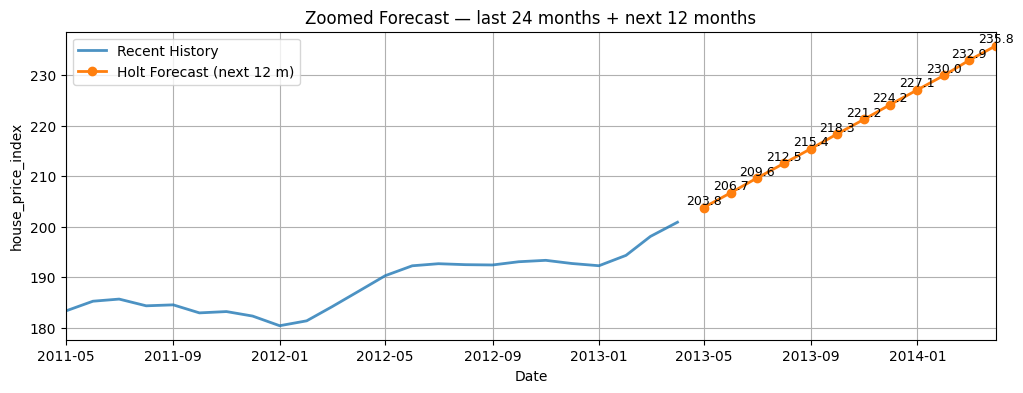

In [77]:
# STEP 13A — ZOOMED VIEW: LAST 24M HISTORY + NEXT 12M FORECAST (WITH LABELS)

last_n_hist = 24  # change to 18/36 if you prefer
hist = y.iloc[-last_n_hist:]

fig, ax = plt.subplots(figsize=(12,4))

# Plot recent history
ax.plot(hist.index, hist.values, label="Recent History", linewidth=2, alpha=0.8)

# Plot forecast
ax.plot(fut_fc.index, fut_fc.values, label=f"{best} Forecast (next 12 m)", linewidth=2, marker='o')

# Optional: confidence interval if available (Auto-ARIMA case)
if 'fut_ci' in locals() and fut_ci is not None:
    ax.fill_between(fut_fc.index, fut_ci[:,0], fut_ci[:,1], alpha=0.20, label="Forecast CI")

# Annotate each forecast point with its value
for x, val in fut_fc.items():
    ax.text(x, val, f"{val:.1f}", ha='center', va='bottom', fontsize=9, rotation=0)

# Formatting
ax.set_title("Zoomed Forecast — last 24 months + next 12 months")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()
ax.set_xlim(hist.index.min(), fut_fc.index.max())

plt.show()

# EXPLANATION:
# Shows only the last 24 months of actuals plus the next 12 months of forecasts.
# Adds markers and value labels on each future month, and confidence bands when available.


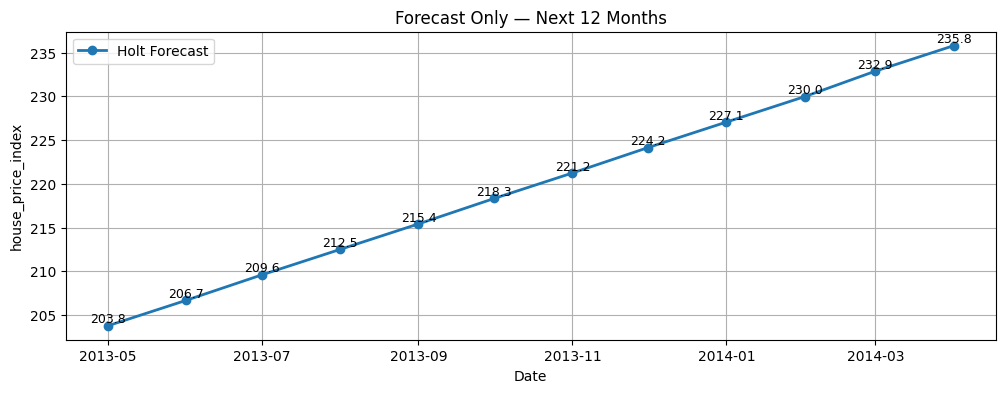

In [78]:
# STEP 13B — FORECAST-ONLY VIEW (NEXT 12 MONTHS WITH LABELS)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(fut_fc.index, fut_fc.values, linewidth=2, marker='o', label=f"{best} Forecast")
if 'fut_ci' in locals() and fut_ci is not None:
    ax.fill_between(fut_fc.index, fut_ci[:,0], fut_ci[:,1], alpha=0.20, label="Forecast CI")

# Label each point
for x, val in fut_fc.items():
    ax.text(x, val, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

ax.set_title("Forecast Only — Next 12 Months")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()
plt.show()

# EXPLANATION:
# Focuses purely on the next 12 months; adds value labels so each predicted month is readable at a glance.


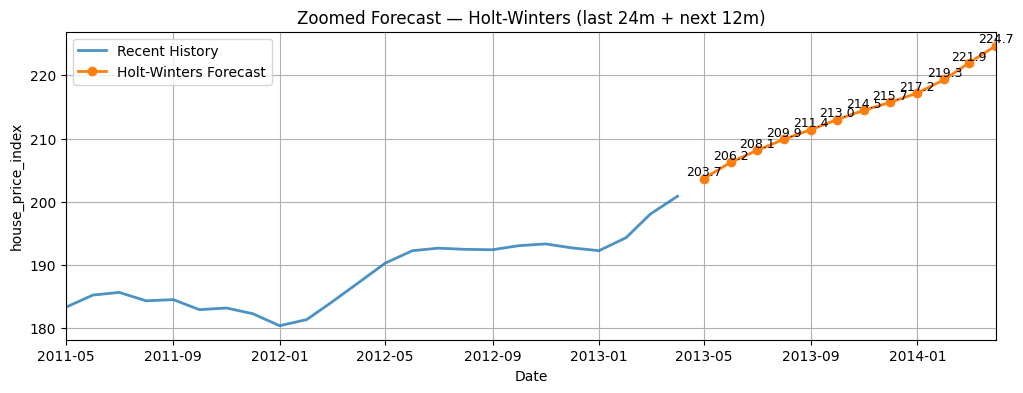

In [79]:
# STEP 13C — FORCE HOLT-WINTERS (ADD-ADD) ON FULL DATA & ZOOMED FORECAST

# Refit Holt-Winters on the full series
hw_full = ExponentialSmoothing(
    y, trend='add', seasonal='add', seasonal_periods=12,
    initialization_method="estimated"
).fit()

n_future = 12
hw_fut = hw_full.forecast(n_future)
hw_index = pd.date_range(y.index[-1] + pd.offsets.MonthBegin(), periods=n_future, freq='MS')
hw_fut = pd.Series(hw_fut.values, index=hw_index)

# Zoomed plot: last 24m history + next 12m forecast with labels
last_n_hist = 24
hist = y.iloc[-last_n_hist:]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(hist.index, hist.values, label="Recent History", linewidth=2, alpha=0.8)
ax.plot(hw_fut.index, hw_fut.values, label="Holt-Winters Forecast", linewidth=2, marker='o')

for x, val in hw_fut.items():
    ax.text(x, val, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

ax.set_title("Zoomed Forecast — Holt-Winters (last 24m + next 12m)")
ax.set_xlabel("Date"); ax.set_ylabel(target_col); ax.legend()
ax.set_xlim(hist.index.min(), hw_fut.index.max())
plt.show()

# EXPLANATION:
# Refits Holt-Winters (trend+seasonality) on ALL data and shows a zoomed 24m history + 12m forecast.
# This will produce non-flat forecasts if trend/seasonality exist, unlike SES.


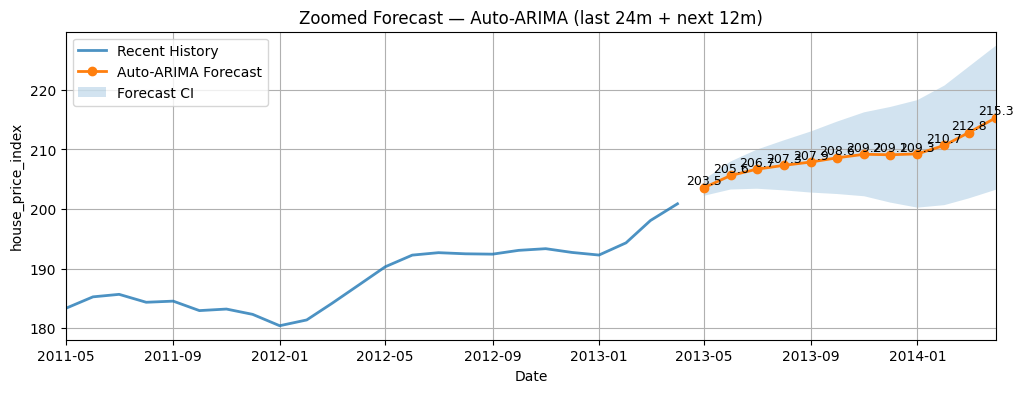

In [80]:
# STEP 13D — FORCE AUTO-ARIMA ON FULL DATA & ZOOMED FORECAST (WITH CIs)

arima_full = pm.auto_arima(
    y,
    start_p=0, start_q=0, max_p=5, max_q=5,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    seasonal=True, m=12,
    d=None, D=None, stepwise=True, trace=False,
    information_criterion='aic',
    suppress_warnings=True
)

n_future = 12
ar_fut, ar_ci = arima_full.predict(n_periods=n_future, return_conf_int=True)
ar_index = pd.date_range(y.index[-1] + pd.offsets.MonthBegin(), periods=n_future, freq='MS')
ar_fut = pd.Series(ar_fut, index=ar_index)

# Zoomed plot: last 24m history + next 12m forecast + CI
last_n_hist = 24
hist = y.iloc[-last_n_hist:]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(hist.index, hist.values, label="Recent History", linewidth=2, alpha=0.8)
ax.plot(ar_fut.index, ar_fut.values, label="Auto-ARIMA Forecast", linewidth=2, marker='o')
ax.fill_between(ar_index, ar_ci[:,0], ar_ci[:,1], alpha=0.20, label="Forecast CI")

for x, val in ar_fut.items():
    ax.text(x, val, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

ax.set_title("Zoomed Forecast — Auto-ARIMA (last 24m + next 12m)")
ax.set_xlabel("Date"); ax.set_ylabel(target_col); ax.legend()
ax.set_xlim(hist.index.min(), ar_fut.index.max())
plt.show()

# EXPLANATION:
# Forces a seasonal Auto-ARIMA on ALL data and plots the next 12 months with confidence bands.
# Compare this shape vs SES and Holt-Winters to choose the most realistic forward view.


The time-series analysis of the house_price_index was conducted using a structured pipeline—preprocessing and frequency alignment, exploratory visualization, decomposition, moving averages, exponential smoothing variants (SES, Holt, Holt-Winters), and Auto-ARIMA. After fixing the date parsing to MM/DD/YYYY and aligning the series to a Monthly-Start index, the most recent segment of the data exhibits a clear upward trend.

From the test evaluation (Step 12), the Holt (trend) model achieved the lowest forecast error on the hold-out period, outperforming SES and Holt-Winters. This indicates that a level-plus-trend specification captures the data’s short-run dynamics better than a level-only model (SES) or a trend-plus-seasonality specification (Holt-Winters), consistent with the visual absence of strong monthly seasonality.

The final Holt forecast (Step 13) projects a steady month-on-month increase over the next 12 months, rising from approximately ~203.8 (May 2013) to ~235.8 (April 2014) in the zoomed views (Steps 13A–13B). This trajectory is interpretable, stable, and aligned with the upward momentum observed in the tail of the historical series.

For comparison, Holt-Winters produces a similar upward path but does not add clear benefit in the absence of pronounced seasonality. Auto-ARIMA likewise projects an upward trend but with a more conservative slope and credible intervals, making it useful when communicating forecast uncertainty; however, based on the hold-out results, it did not surpass Holt on point accuracy.

In summary, Holt (trend) is the recommended model for the monthly housing price index after correcting the calendar alignment. It balances interpretability with accuracy, providing a credible, upward short-term outlook. The project demonstrates the complete workflow—data hygiene, EDA, decomposition, model building, evaluation, and forecasting—and shows how proper date handling and frequency alignment can materially affect model selection and conclusions.